# Zip code distribution analysis for "geochunk" algorithm

Our goal is to group zip codes by variable length prefixes in such a way that the chunk sizes tend to be roughly equal, with no giant, leftover chunks.

But first, we need to import some standard Python data libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We have some zip code census data from [this blog post](https://blog.splitwise.com/2013/09/18/the-2010-us-census-population-by-zip-code-totally-free/) that we want to load and examine. We need to do this `np.object_` business to force the CSV parser to treat zip codes as strings, and not as integers (thus losing the leading zeroes).

In [2]:
zippop = pd.read_csv('../src/zip2010.csv', dtype={'Zip Code ZCTA': np.object_, '2010 Census Population': np.int32})
zippop[:10]

,Zip Code ZCTA,2010 Census Population
0,01001,16769
1,01002,29049
2,01003,10372
3,01005,5079
4,01007,14649
5,01008,1263
6,01009,741
7,01010,3609
8,01011,1370
9,01012,661


In [3]:
pop = zippop['2010 Census Population']
pop.sum()

308739931

Let's look at the distribution of population by zip code.

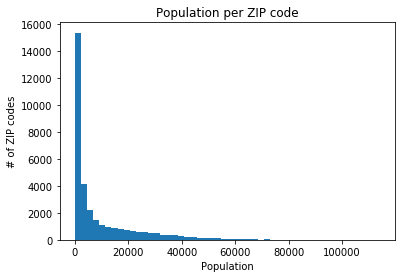

In [4]:
plt.hist(pop, bins=50)
plt.title("Population per ZIP code")
plt.xlabel("Population")
plt.ylabel("# of ZIP codes")

In [5]:
zippop.nlargest(20, '2010 Census Population')

,Zip Code ZCTA,2010 Census Population
20640,60629,113916
27727,79936,111086
2748,11368,109931
30109,90650,105549
29986,90011,103892
30192,91331,103689
2720,11226,101572
30045,90201,101279
2753,11373,100820
2714,11220,99598


In [6]:
zippop.nsmallest(5, '2010 Census Population')

,Zip Code ZCTA,2010 Census Population
75,01199,0
383,02203,0
1423,05481,0
1558,06020,0
1580,06059,0


Now let's look at 4-digit zip code prefixes:

In [7]:
def sum_by_zip_prefix(zippop, length):
    prefixes = zippop['Zip Code ZCTA'].str[:length].rename('Zip Prefix')
    df = pd.concat([prefixes, zippop['2010 Census Population']], axis=1)
    return df.groupby('Zip Prefix').sum().reset_index()
prefix_4 = sum_by_zip_prefix(zippop, 4)
prefix_4.nlargest(10, '2010 Census Population')

,Zip Prefix,2010 Census Population
533,1121,710148
534,1122,621986
498,1046,605938
3773,6062,605797
535,1123,588379
532,1120,584187
497,1045,560238
3772,6061,543914
481,1002,505290
3774,6063,497137


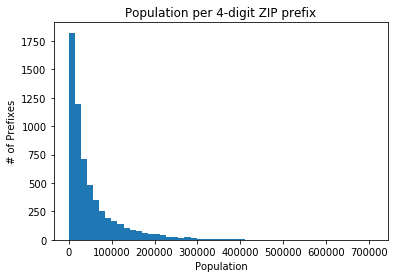

In [8]:
plt.hist(prefix_4['2010 Census Population'], bins=50)
plt.title("Population per 4-digit ZIP prefix")
plt.xlabel("Population")
plt.ylabel("# of Prefixes")

And various shorter prefix lengths. We tried to use 3-digit prefixes for the first Pachynorm run, which as you can, gave us some huge chunks with just under 3 million people.

In [9]:
prefix_3 = sum_by_zip_prefix(zippop, 3)
prefix_3.nlargest(10, '2010 Census Population')

,Zip Prefix,2010 Census Population
699,770,2906700
555,606,2680484
91,112,2504700
803,900,2404395
843,945,2274102
276,300,2177710
679,750,2079278
818,917,1924074
306,331,1885845
59,070,1683417


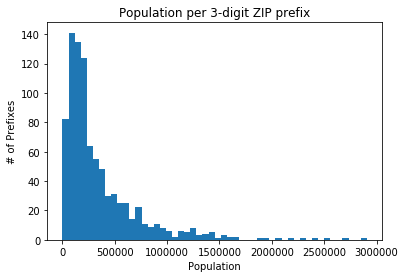

In [10]:
plt.hist(prefix_3['2010 Census Population'], bins=50)
plt.title("Population per 3-digit ZIP prefix")
plt.xlabel("Population")
plt.ylabel("# of Prefixes")

In [11]:
prefix_2 = sum_by_zip_prefix(zippop, 2)
prefix_2.nlargest(10, '2010 Census Population')

,Zip Prefix,2010 Census Population
31,33,9285786
90,92,9033701
58,60,8783167
9,11,7579159
28,30,7254703
75,77,7012758
93,95,6786586
46,48,6634334
76,78,6358782
30,32,6263654


In [12]:
prefix_2.nsmallest(10, '2010 Census Population')

,Zip Prefix,2010 Census Population
67,69,184566
49,51,486400
80,82,520260
86,88,620867
4,05,625741
84,86,644295
56,58,671781
24,26,795935
55,57,813464
79,81,832537


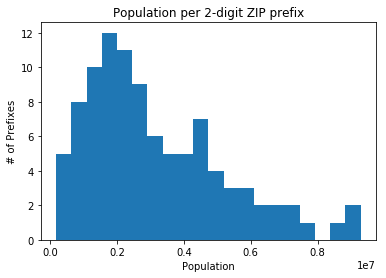

In [13]:
plt.hist(prefix_2['2010 Census Population'], bins=20)
plt.title("Population per 2-digit ZIP prefix")
plt.xlabel("Population")
plt.ylabel("# of Prefixes")

In [14]:
sum_by_zip_prefix(zippop, 1)

,Zip Prefix,2010 Census Population
0,0,23236989
1,1,32978141
2,2,30390138
3,3,42575790
4,4,32249466
5,5,16513346
6,6,23499661
7,7,36345281
8,8,21075552
9,9,49875567


## Variable length chunks

Now that we've explored the data, we're ready to experiment with variable length chunks.  First, we want to build a table that will allow us to quickly look up the population of any prefix from length 0 (the entire country) to length 5 (a single zip).

In [15]:
prefix_populations = [ sum_by_zip_prefix(zippop, prefix).set_index('Zip Prefix') for prefix in range(0,6) ]
def prefix_population(prefix):
    return prefix_populations[len(prefix)]['2010 Census Population'].get(prefix, 0)
[prefix_population('770'), prefix_population('03755')]

[2906700, 10538]

In [16]:
def sub_prefixes(prefix):
    return [ prefix + str(n) for n in range(0,10) ]
sub_prefixes('902')

['9020',
 '9021',
 '9022',
 '9023',
 '9024',
 '9025',
 '9026',
 '9027',
 '9028',
 '9029']

In [17]:
class ZipChunk:
    "A group of zip codes roughly equal in size to all other such chunks."
 
    def __init__(self, id):
        self.id = id
        self.prefixes = []

    def add_prefix(self, prefix):
        self.prefixes.append(prefix)
    
    def population(self):
        return sum([ prefix_population(prefix) for prefix in self.prefixes ])
    
def build_chunks_recursive(population, chunks, prefix):
    lower_limit = population / 2
    upper_limit = population
    if lower_limit < prefix_population(prefix) <= upper_limit or len(prefix) >= 5:
        chunk = ZipChunk(prefix)
        chunk.add_prefix(prefix)
        chunks.append(chunk)
    else:
        leftovers = []
        for child in sub_prefixes(prefix): 
            if prefix_population(child) >= upper_limit:
                build_chunks_recursive(population, chunks, child)
            else:
                leftovers.append(child)
        i = 0
        chunk = ZipChunk("%s_%i" % (prefix, i))
        while len(leftovers) > 0:
            child = leftovers.pop(0)
            assert(prefix_population(child) <= upper_limit)
            if chunk.population() + prefix_population(child) > upper_limit:
                i += 1
                chunks.append(chunk)
                chunk = ZipChunk("%s_%i" % (prefix, i))
            chunk.add_prefix(child)
        if chunk.population() > 0:
            chunks.append(chunk)
    
def build_chunks(population):
    chunks = []
    build_chunks_recursive(population, chunks, '')
    chunks = sorted(chunks, key=lambda chunk: chunk.id)
    result = pd.DataFrame([ (chunk.id, chunk.population(), chunk.prefixes) for chunk in chunks ])
    result.columns = ['Chunk', '2010 Census Population', 'Prefixes']
    result.set_index('Chunk', inplace=True)
    return result

chunks = build_chunks(100000)
chunks

,2010 Census Population,Prefixes
Chunk,,
010_0,77922,[0100]
010_1,96062,"[0101, 0102]"
010_2,76753,"[0103, 0104]"
010_3,73002,"[0105, 0106]"
010_4,37535,[0107]
010_5,88283,[0108]
010_6,19818,[0109]
0110_0,92014,"[01100, 01101, 01102, 01103, 01104, 01105, 011..."
0110_1,30250,[01109]


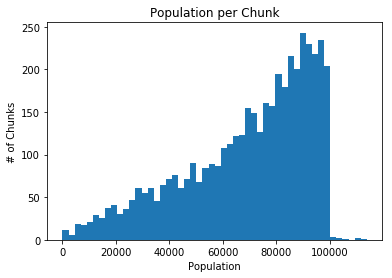

In [18]:
plt.hist(chunks['2010 Census Population'], bins=50)
plt.title("Population per Chunk")
plt.xlabel("Population")
plt.ylabel("# of Chunks")

In [19]:
chunks['2010 Census Population'].sum()

308739931

In [20]:
chunks.shape

(4444, 2)

In [21]:
chunks_250000 = build_chunks(250000)
chunks_250000

,2010 Census Population,Prefixes
Chunk,,
010_0,210857,"[0100, 0101, 0102, 0103]"
010_1,238700,"[0104, 0105, 0106, 0107, 0108]"
010_2,19818,[0109]
015_0,244841,"[0150, 0151, 0152, 0153, 0154, 0155]"
015_1,128878,"[0156, 0157, 0158, 0159]"
017_0,207777,"[0170, 0171, 0172, 0173, 0174]"
017_1,171250,"[0175, 0176, 0177, 0178, 0179]"
018_0,184413,"[0180, 0181, 0182]"
018_1,227505,"[0183, 0184]"


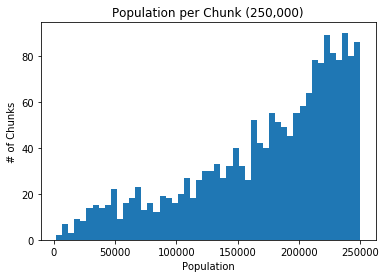

In [22]:
plt.hist(chunks_250000['2010 Census Population'], bins=50)
plt.title("Population per Chunk (250,000)")
plt.xlabel("Population")
plt.ylabel("# of Chunks")

In [23]:
chunks_250000.to_csv('geochunk_zip_250000.csv')

In [24]:
chunks_500000 = build_chunks(500000)
chunks_500000

,2010 Census Population,Prefixes
Chunk,,
018_0,411918,"[0180, 0181, 0182, 0183, 0184]"
018_1,301208,"[0185, 0186, 0187, 0188, 0189]"
01_0,469375,[010]
01_1,382635,"[011, 012, 013]"
01_2,211812,[014]
01_3,373719,[015]
01_4,188402,[016]
01_5,379027,[017]
01_6,476314,[019]


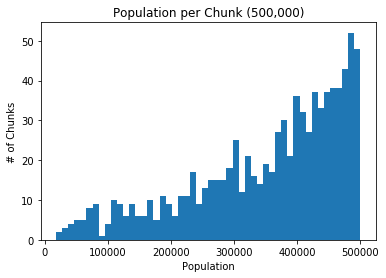

In [25]:
plt.hist(chunks_500000['2010 Census Population'], bins=50)
plt.title("Population per Chunk (500,000)")
plt.xlabel("Population")
plt.ylabel("# of Chunks")